# Final Project: Climate Modelling with python

## Tim Aguirre

## PHYS 300

## What is climate modeling?

   Climate modelling is the the use of numerical climate models that use quantitative methods to simulate the interactions the important drivers of climate, including atmosphere, oceans, land surface and ice. It is used not only to study the dynamics of the climate system, but also to predict future outcomes of the climate including projections for climate change and global warming. An example of this can be seen below which detail sea surface temperatures around the globe:
    
    
    
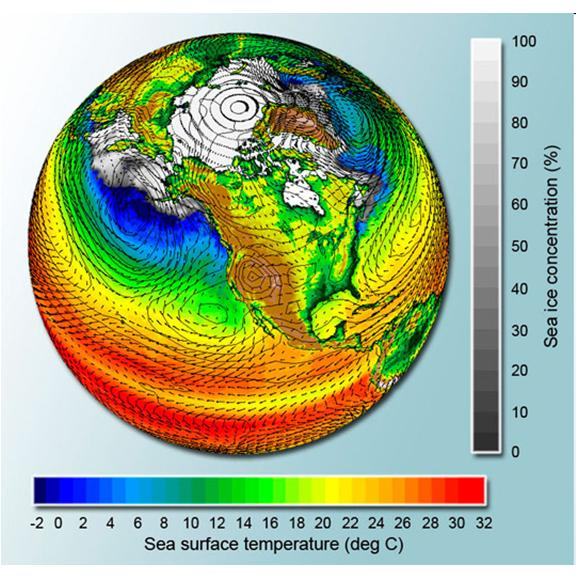


## Why is it important?
   
   As global warming gets worse, we need to reliably predict the negative consequences of this outcome to prevent damages from catastrophic natural disasters. Using climate modeling, we are able to predict not only global temperatures, but also predict its effects on wind and water currents. Using factors such as carbon concentration, radiation, and convection currents, we are able to form a model of the earth and find out what it may come to be within the near future.
   

# Background Info

## CliMT (Climate Modelling and Diagnostics Toolkit)

This will be the main repository we will be using called CliMT. It can produce a modular Earth system and planetary model that simulates the planet under certain conditions. It contains several "components" that dictate what will happen to the earth making it into a "state." This state is what we can show in an earth model. Some important components to be defined are:

    1. Radiation which dictates the reactions that heat has within the earth
    2. Convection which dictates the motion of wind within the earth dictated by external gravity and rotation
    3. Surface processes which dictates the interactions of the wind with the terrain of the earth
    4. Ice Processes which dictate the interactions of the ice sheets with the climate

## Probabilities and Bayesian Inference

The main form of math that will be used with this program is Bayesian inference, which gives a probability based on the previous probabilities given within a situation. This is best seen in an event like rain probability where you take the prior probability and combine it with the likelihood of its occurrence to predict the probability it will occur again in the future. Shown in the equation below is this example:

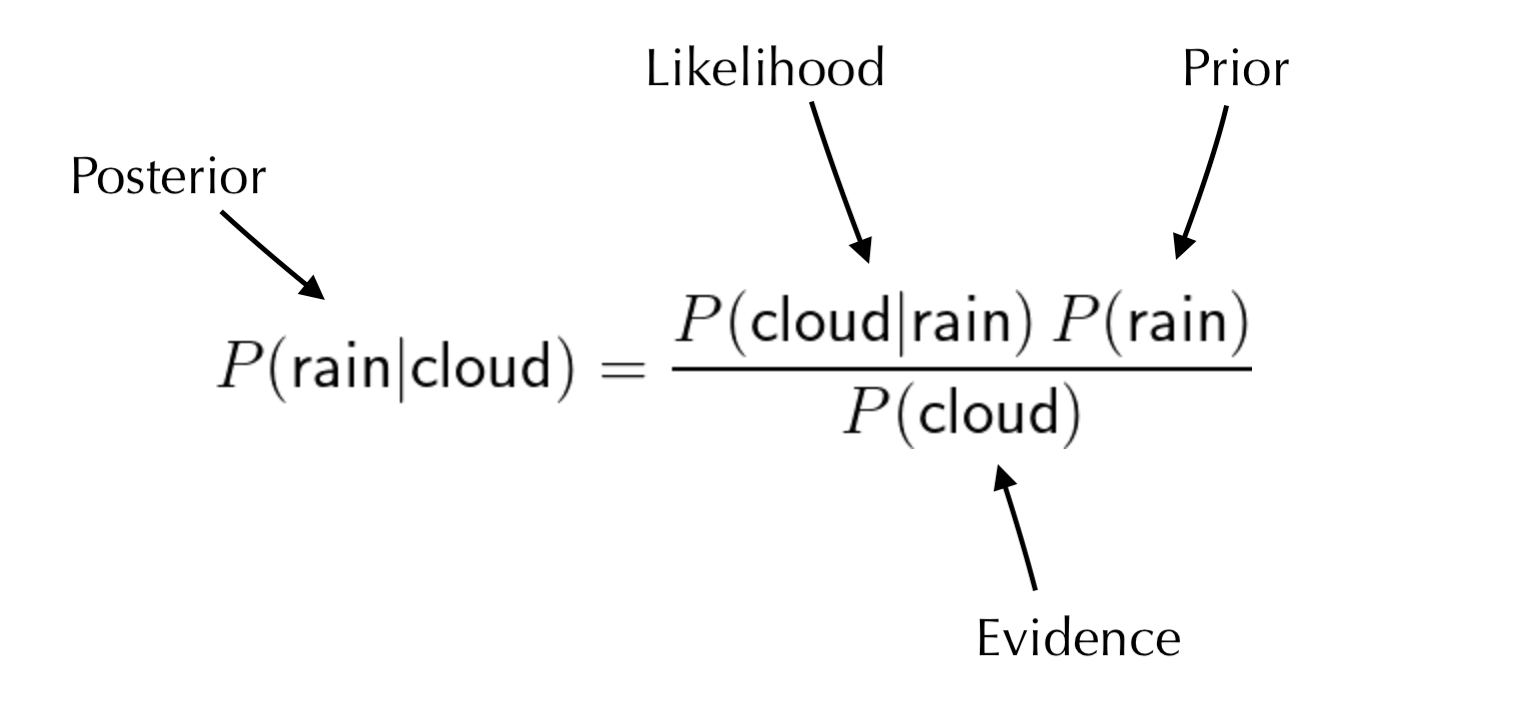



## Imports

In [55]:
import climt
import sympl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from sympl import AdamsBashforth
from datetime import timedelta

# Graphing Functions

These two functions are used for graphing and displaying the models that is created using climt

In [80]:
def plot_vertical_profile(state, plot_names=['eastward_wind', 'air_temperature']):
    """Plots all zonal winds for different rotation rates"""
    fig = plt.figure(figsize=(10,3))
    for i in range(len(plot_names)):
        ax = fig.add_subplot(1, 3, i+1)
        state[plot_names[i]].coords['lat'] = state['latitude'][:,0]
        state[plot_names[i]].mean(dim='lon').plot.contourf(
            ax=ax, levels=16, robust=True)
        ax.set_title(plot_names[i].replace('_',' '))
    plt.tight_layout()
    fig.subplots_adjust(top=0.8)
    plt.suptitle(state['time'], fontsize=20)


import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
def plot_sfc_map(state, plot_names = ['eastward_wind', 'air_temperature', 'surface_geopotential']):
    """Plots all zonal winds for different rotation rates"""
    fig = plt.figure(figsize=(9,5))
    for i in range(len(plot_names)):
        ax = fig.add_subplot(2, 2, i+1, projection=ccrs.PlateCarree())
        state[plot_names[i]].coords['lat'] = state['latitude'][:,0]
        state[plot_names[i]].coords['lon'] = state['longitude'][0]
        if 'surface' in plot_names[i]:
            plot_state = state[plot_names[i]]
        else : 
            plot_state = state[plot_names[i]][0]
        data = plot_state
        data, lon = add_cyclic_point(data, coord=state['longitude'][0])
        lat = state['latitude'][:,0]
        if np.min(data)<0.:
            levels = np.linspace(-np.max(np.abs(data)), np.max(np.abs(data)), 9)
            cmap = 'RdBu_r'
            plt.contourf(lon, lat, data, cmap=cmap, levels = levels, robust=True)

        else:
            plt.contourf(lon, lat, data, robust=True)
        plt.colorbar()
        plt.tight_layout()
        ax.set_title(plot_names[i].replace('_',' '))
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.set_aspect('auto', adjustable=None)
    plt.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.suptitle('Surface Map', fontsize=16)
    

plt.show()

# Conditions

The only condition I will be manipulating will be the radiation and surface because I have importing issues with climt that most likely has to do with the fortran wrapping.

For this model I will be making the timestep change by 5 hours every model, and I will be using the GrayLongWave radiation model, which is just a linear radiation model as well as SlabSurface surface model, which places the surface of the earth in slabs (inaccuracte measurements).



In [77]:
# Timestep creates the different models at these intervals
timestep = timedelta(hours=5)

# Radiation: only call every 1 hr
radiation_timestep = timedelta(minutes=60)
radiation = sympl.UpdateFrequencyWrapper(climt.GrayLongwaveRadiation(), 
                                         radiation_timestep)
# Surface component that dictates how the surface interacts with the wind and heat.
surface = climt.SlabSurface()

# Initializes a model for the radiation
model = AdamsBashforth([radiation, surface])

# Initializing The State

We can then initialize the state and start the model of our world and graph it to see what our model looks like at the beginning

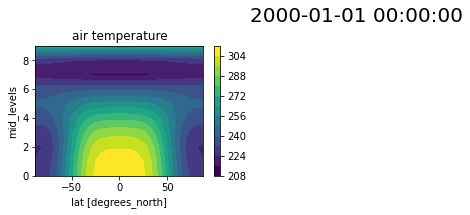

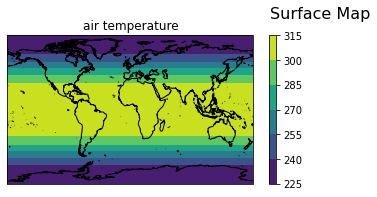

In [78]:
# Initializing the state further
grid = climt.get_grid(nx=62, ny=62, nz=10)
#dycore = climt.GFSDynamicalCore([radiation, surface], number_of_damped_levels=5)
state = climt.get_default_state([radiation, surface, convection], grid_state=grid)

# Graphing the state of our model
dcmip = climt.DcmipInitialConditions(add_perturbation=False)
init_state = dcmip(state)
state.update(init_state)
plot_vertical_profile(state, plot_names=['air_temperature'])
plot_sfc_map(state, plot_names=['air_temperature'])

# Predicting

Using this initialized model, we can step forward in time to see what the model will become. Putting it in a loop can show us the gradual changing of the earth which we can then study to make predictions for our own world.

Note: These models and predictions will not be anywhere near accurate to the real life conditions of the earth, I had to use the most basic models the repository offered since I was facing issues with Fortran

Earth model 71
Earth model 143
Earth model 215
Earth model 287
Earth model 359
Earth model 431


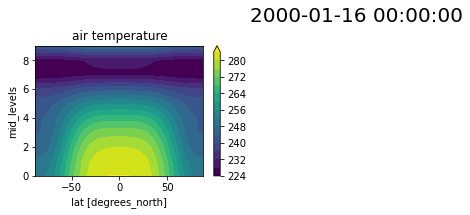

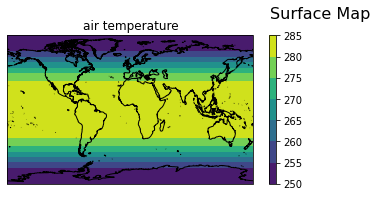

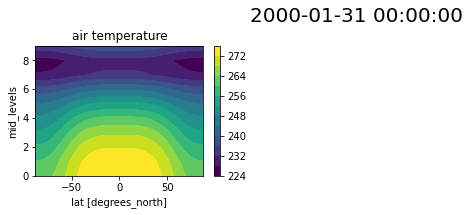

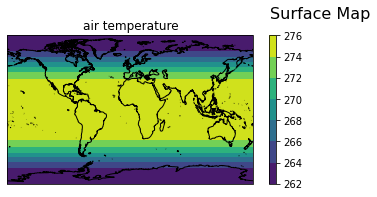

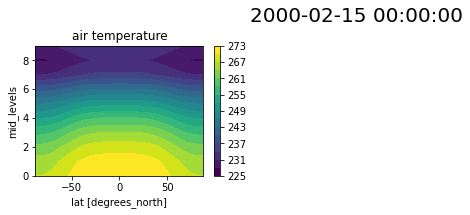

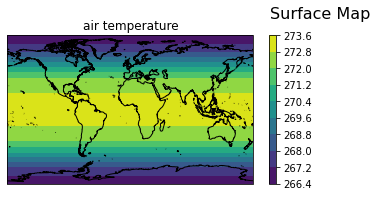

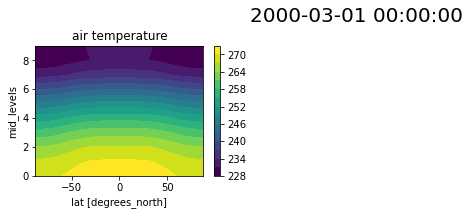

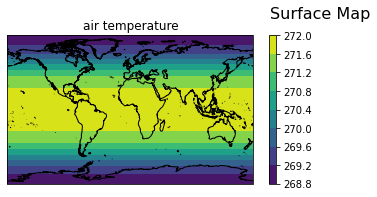

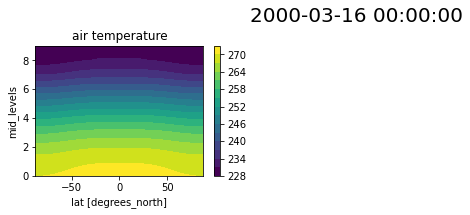

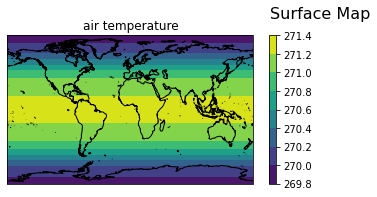

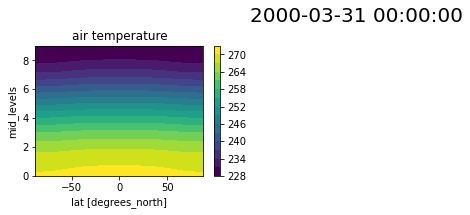

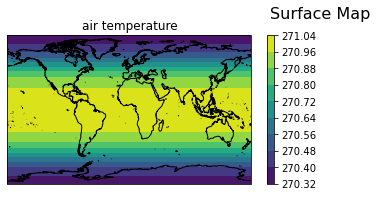

In [72]:
for i in range(3*24*6):
    diagnostics, new_state = model(state, timestep)
    state.update(diagnostics)
    state.update(new_state)
    state['time'] += timestep
    if (i+1)%(3*24) == 0:
        print("Earth model", i)
        plot_vertical_profile(state, plot_names=['air_temperature'])
        plot_sfc_map(state, plot_names=['air_temperature'])

# Further research and possibilities

This is just the basic things that a program like this can achieve. Using its more advanced and accurate conditions can net you a very accurate depiction of the earths conditions after certain conditions are met. The fact that its fortran based also means you are not constrained to simply using Python and you could contribute to this project by adding your own modelling of conditions.

You could even use this to model the effects of climate change on the wind and the atmosphere. In fact for this model you can see other important information about the model such as:

    1. Eastward Wind
    2. Air temperature
    3. Surface geopotential
    4. Divergence of Wind 
    5. Atmospheric relative vorticity

I opted to only show the air temperature as that is radiation is the only variable I am able to control and there wouldn't be any differences between the wind and atmospheric conditions. I am specifically unable to show the last two as those are only initiated when a convection condition is defined.

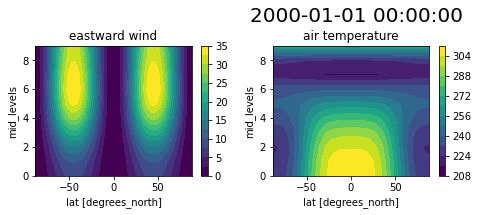

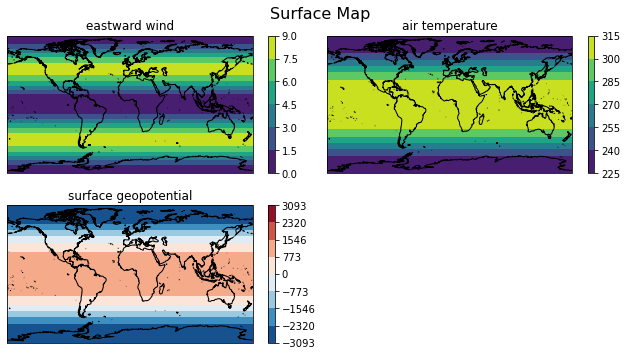

In [81]:
plot_vertical_profile(state)
plot_sfc_map(state)

# References

1. https://github.com/informatics-lab/probabilistic-programming/blob/master/04_IntroToClimt_Blog.ipynb

2. https://climt.readthedocs.io/en/latest/introduction.html

3. https://medium.com/informatics-lab/simple-climate-modelling-in-python-43d0d0b4af03